# Chatbot Application with Tool Calling (LangGraph + LangChain)

This notebook walks you through building a **tool-calling chatbot** using:

- **LangGraph** for orchestration (graph-based control flow)
- **LangChain** `ChatOpenAI` for the LLM
- A small toolset:
  - Web search (DuckDuckGo)
  - Calculator
  - Stock price lookup (no API key required; uses **Stooq** free CSV endpoint)

By the end, you will have a chatbot that can:
- Answer normally when no tools are needed
- Call tools when required (math, web search, stock price)
- Chain tools (e.g., stock price → calculator)

---

## Prerequisites

1. A Python environment (recommended: `python>=3.10`)
2. Your environment variables set (recommended via `.env`)
3. Installed dependencies (see next cell)

> **Important:** Do not commit real API keys to GitHub. Use `.env` + `.gitignore`.


In [7]:
# If you need to install dependencies, uncomment and run this cell.
# %pip install -U langgraph langchain langchain-openai langchain-community python-dotenv requests

## Environment variables

Set the following variables (via your shell or a `.env` file).
### Recommended: `.env` file

Create a file named `.env` in the same folder as this notebook:

```bash
OPENAI_API_KEY="sk-..."
LANGCHAIN_TRACING_V2=true
LANGCHAIN_ENDPOINT="https://api.smith.langchain.com"
LANGSMITH_API_KEY="ls-..."
LANGCHAIN_PROJECT="Chatbot Tools"
```

Then keep it out of version control by adding to `.gitignore`:

```bash
.env
```

Next cell will **load** `.env` and validate the configuration.

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

required_env = [
    "OPENAI_API_KEY",
    "LANGCHAIN_TRACING_V2",
    "LANGCHAIN_ENDPOINT",
    "LANGSMITH_API_KEY",
    "LANGCHAIN_PROJECT",
]

missing = [k for k in required_env if not os.getenv(k)]
if missing:
    raise EnvironmentError(
        "Missing required environment variables: "
        + ", ".join(missing)
        + "\n\nTip: create a .env file next to this notebook and re-run this cell."
    )

print("Environment looks good!")
print("LANGCHAIN_PROJECT:", os.getenv("LANGCHAIN_PROJECT"))

Environment looks good!
LANGCHAIN_PROJECT: Chatbot Tools


## Step 1 — Imports

We import:
- LangGraph primitives (`StateGraph`, `START`, `END`)
- Message types and message reducer (`add_messages`)
- Tools framework (`@tool`, `ToolNode`, `tools_condition`)
- A web search tool (DuckDuckGo)
- `requests` for stock price fetching



In [2]:
import warnings

warnings.filterwarnings(
    "ignore",
    message=r"Core Pydantic V1 functionality isn't compatible with Python 3\.14 or greater\.",
    category=UserWarning,
    module=r"langchain_core\._api\.deprecation",
)

In [3]:
import requests
import csv
import io
from typing import Annotated, Literal, TypedDict

from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


## Step 2 — Define tools

We will add three tools:

1. **`search_web`**: DuckDuckGo web search
2. **`calculator`**: basic arithmetic (add/sub/mul/div)
3. **`get_stock_price`**: fetch latest price from Stooq (free endpoint, no API key)

### Notes on stock pricing

- Stooq expects symbols like `aapl.us`, `tsla.us`.
- This tool accepts either:
  - A ticker (`AAPL`, `TSLA`)
  - A name (`Apple`, `Tesla`) for a few common companies (simple mapping)
- For unknown names, the tool returns a helpful error and suggests using the web search tool.



In [5]:
# Web search tool (DuckDuckGo)
search_web = DuckDuckGoSearchRun(region="us-en")


@tool
def calculator(
    first_num: float,
    second_num: float,
    operation: Literal["add", "sub", "mul", "div"],
) -> dict:
    """Perform a basic arithmetic operation on two numbers.

    Args:
        first_num: First number.
        second_num: Second number.
        operation: One of: "add", "sub", "mul", "div".

    Returns:
        A dict containing inputs and the computed "result", or an "error".
    """
    if operation == "div" and second_num == 0:
        return {"error": "Division by zero is not allowed."}

    try:
        if operation == "add":
            result = first_num + second_num
        elif operation == "sub":
            result = first_num - second_num
        elif operation == "mul":
            result = first_num * second_num
        else:  # div
            result = first_num / second_num

        return {
            "first_num": first_num,
            "second_num": second_num,
            "operation": operation,
            "result": result,
        }
    except Exception as e:
        return {"error": str(e)}


@tool
def get_stock_price(symbol_or_name: str) -> dict:
    """Fetch a recent stock price from Stooq (free CSV endpoint; no API key).

    This tool accepts either:
      - A ticker symbol (e.g., "AAPL", "TSLA")
      - A common company name (e.g., "Apple", "Tesla") for a small built-in mapping

    Stooq symbol format is typically:
      - US stocks: "<ticker>.us" (lowercase)
      Example: "aapl.us", "tsla.us"

    Args:
        symbol_or_name: Company name or ticker symbol.

    Returns:
        Dict with resolved symbol and the latest close price (if available),
        or a dict with "error".
    """
    q = (symbol_or_name or "").strip().lower()
    if not q:
        return {"error": "symbol_or_name is empty."}

    # Simple mapping for common names (extend as needed)
    name_to_ticker = {
        "apple": "aapl.us",
        "tesla": "tsla.us",
        "microsoft": "msft.us",
        "amazon": "amzn.us",
        "nvidia": "nvda.us",
        "google": "googl.us",
        "alphabet": "googl.us",
        "meta": "meta.us",
    }

    # Resolve to a Stooq symbol
    if q in name_to_ticker:
        stooq_symbol = name_to_ticker[q]
    else:
        # If user typed "AAPL" -> "aapl.us"
        # If user typed "aapl.us" keep as-is
        if "." in q:
            stooq_symbol = q
        else:
            # assume ticker
            stooq_symbol = f"{q}.us"

    url = "https://stooq.com/q/l/"
    params = {"s": stooq_symbol, "f": "sd2t2ohlcv", "h": "", "e": "csv"}

    try:
        r = requests.get(url, params=params, timeout=12)
        r.raise_for_status()

        # Parse CSV
        content = r.text.strip()
        if not content or "No data" in content:
            return {
                "error": f"No data returned for symbol '{stooq_symbol}'.",
                "tip": "Try providing a valid US ticker like AAPL or use search_web to find the correct ticker.",
            }

        reader = csv.DictReader(io.StringIO(content))
        rows = list(reader)
        if not rows:
            return {"error": f"Could not parse CSV for symbol '{stooq_symbol}'."}

        row = rows[0]

        # Close price is in 'Close'
        close = row.get("Close")
        date = row.get("Date")
        time = row.get("Time")

        # Stooq sometimes returns empty values for invalid symbols
        if not close or close in ("-", ""):
            return {
                "error": f"Price not available for '{stooq_symbol}'.",
                "raw": row,
            }

        return {
            "input": symbol_or_name,
            "resolved_symbol": stooq_symbol,
            "date": date,
            "time": time,
            "close": float(close),
            "currency_note": "Stooq data may be delayed; verify with your broker for trading decisions.",
        }

    except requests.exceptions.RequestException as e:
        return {"error": f"HTTP error: {str(e)}", "resolved_symbol": stooq_symbol}
    except Exception as e:
        return {"error": str(e), "resolved_symbol": stooq_symbol}


# Tool list for the agent
tools = [search_web, calculator, get_stock_price]


## Step 3 — Create the tool-aware LLM

We bind the tools to the LLM so it can decide when to call them.

Tips:
- `temperature=0` is recommended for consistent tool routing.
- You can choose another model name if your account supports it.



In [6]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm_with_tools = llm.bind_tools(tools)

## Step 4 — Define LangGraph state

We store the conversation as a list of messages.

LangGraph's `add_messages` reducer will automatically append new messages returned from nodes.



In [7]:
class ChatState(TypedDict):
    """Graph state containing the conversation messages."""
    messages: Annotated[list[BaseMessage], add_messages]

## Step 5 — Define nodes: Chat node + Tool node

- `chat_node` runs the LLM. It may return:
  - a normal assistant response, or
  - a tool call request (function call)
- `ToolNode` executes tool calls emitted by the model.

We also add a small system prompt to guide tool usage.



In [8]:
SYSTEM_PROMPT = SystemMessage(
    content=(
        "You are a helpful assistant. Use tools when needed.\n"
        "- For arithmetic, use calculator.\n"
        "- For web lookups, use search_web.\n"
        "- For stock prices, use get_stock_price. The tool accepts a ticker (AAPL) or a few common company names (Apple).\n"
        "After a tool returns results, explain them clearly."
    )
)

def chat_node(state: ChatState) -> dict:
    """Run the LLM on the current message list.

    Ensures a system prompt exists at the start for consistent tool behavior.
    Returns a list with the new assistant message, which is appended by the reducer.
    """
    msgs = state["messages"]
    if not msgs or msgs[0].type != "system":
        msgs = [SYSTEM_PROMPT] + msgs

    response = llm_with_tools.invoke(msgs)
    return {"messages": [response]}

tool_node = ToolNode(tools)

## Step 6 — Build and compile the graph

Flow:
1. Start → `chat_node`
2. If model requests tools → `tools`
3. Tool results → back to `chat_node`
4. If no tool request → End

The routing is handled by `tools_condition`.



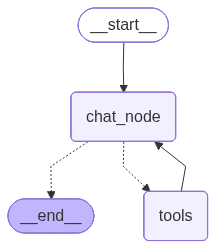

In [9]:
graph = StateGraph(ChatState)

graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

graph.add_edge(START, "chat_node")
graph.add_conditional_edges("chat_node", tools_condition)  # routes to "tools" or END
graph.add_edge("tools", "chat_node")

chatbot = graph.compile()
chatbot


## Step 7 — Single-turn demos

Each `invoke` below starts a new conversation.  
This is useful for quick tests.



In [10]:
# Simple chat (no tools needed)
out = chatbot.invoke({"messages": [HumanMessage(content="Hello!")]})

print(out["messages"][-1].content)


Hello! How can I assist you today?


In [11]:
# Math question: should trigger calculator
out = chatbot.invoke({"messages": [HumanMessage(content="What is 2*3?")]})

print(out["messages"][-1].content)

The result of \(2 \times 3\) is \(6\).


In [12]:
# Stock question: should call get_stock_price
out = chatbot.invoke({"messages": [HumanMessage(content="What is the stock price of Apple?")]})

print(out["messages"][-1].content)

The current stock price of Apple (AAPL) is $245.14. Please note that this data may be delayed, so it's advisable to verify with your broker for any trading decisions.


In [13]:
# Multi-tool chain: stock price then calculate cost for 50 shares
out = chatbot.invoke({
    "messages": [
        HumanMessage(content="First get the stock price of Apple, then calculate how much 50 shares would cost.")
    ]
})

print(out["messages"][-1].content)

The current stock price of Apple (AAPL) is $245.31. 

If you were to buy 50 shares, it would cost you a total of $12,265.50.


## Step 8 — Multi-turn conversation helper (recommended)

In real chatbot applications you want to **preserve context**.  
This helper appends the next user message to the existing message history and runs the graph again.



In [14]:
def run_turn(messages: list[BaseMessage], user_text: str) -> list[BaseMessage]:
    """Run one conversational turn while preserving history.

    Args:
        messages: Existing conversation messages.
        user_text: New user message content.

    Returns:
        Updated list of messages including model/tool outputs.
    """
    messages = messages + [HumanMessage(content=user_text)]
    out = chatbot.invoke({"messages": messages})
    return out["messages"]

# Start a conversation
msgs: list[BaseMessage] = []

msgs = run_turn(msgs, "Hi!")
print(msgs[-1].content)

Hello! How can I assist you today?


In [15]:
msgs = run_turn(msgs, "Can you search for the latest LangGraph docs and summarize in 3 bullets?")
print(msgs[-1].content)

Here are three key points from the latest LangGraph documentation:

1. **Retrieval-Augmented Generation (RAG)**: LangGraph integrates RAG, which enhances large language models (LLMs) by retrieving relevant external documents to provide contextual information for generating answers.

2. **Workflows and Nodes**: The framework allows users to create complex AI workflows by arranging nodes, which are individual units of work (essentially Python functions) that perform specific tasks within the application.

3. **APIs and Resources**: LangGraph offers a set of APIs for programmatic interaction with its components, and users can clone the GitHub repository to access example notebooks for practical implementation and customization of workflows.


In [16]:
msgs = run_turn(msgs, "Now compute (12.5 * 8) / 2 using the calculator.")
print(msgs[-1].content)

The result of the calculation \((12.5 \times 8) / 2\) is \(50.0\).


## Troubleshooting

### 1) `AuthenticationError` or OpenAI key issues
- Ensure `OPENAI_API_KEY` is set.
- Re-run the environment cell after editing `.env`.

### 2) LangSmith tracing not showing
- Confirm:
  - `LANGCHAIN_TRACING_V2=true`
  - `LANGCHAIN_ENDPOINT` is correct
  - `LANGSMITH_API_KEY` is valid
  - `LANGCHAIN_PROJECT` is set
- Then re-run the notebook from the top.

### 3) Stock price tool returns “No data”
- Stooq symbols vary by market.
- Try a known US ticker like `AAPL`, `TSLA`, `MSFT`.
- If you need broader coverage/real-time quotes, use a market data provider.

---

## Next steps (production ideas)
- Add memory (summarization / windowed history)
- Add safety/validation layers for tool inputs
- Add caching for web and price lookups
- Add more tools: calendar, database query, file retrieval, etc.

